In [1]:
import numpy as np
import keras
import pandas as pd 
from keras.models import Sequential
from keras.layers import Dense, Dropout, Embedding, LSTM,Bidirectional,GlobalMaxPooling1D
import re
import tensorflow as tf
from keras.preprocessing.text import Tokenizer

In [2]:
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Activation, Conv2D, Input, Embedding, Reshape, MaxPool1D, Concatenate, Flatten, Dropout, Dense, Conv1D
from keras.models import Model
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.optimizers import Adam,SGD
import warnings
warnings.filterwarnings('ignore')
import seaborn as sns

In [3]:
import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

/kaggle/input/3-classes-bangla-sa/3_classes_Bert_Preprocessed__Dataset.xlsx


In [4]:
pip install openpyxl

     |████████████████████████████████| 242 kB 905 kB/s            
Note: you may need to restart the kernel to use updated packages.


In [5]:
df=pd.read_excel('/kaggle/input/3-classes-bangla-sa/3_classes_Bert_Preprocessed__Dataset.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15728 entries, 0 to 15727
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  15728 non-null  int64 
 1   Data        15728 non-null  object
 2   Label       15728 non-null  int64 
 3   Token       15728 non-null  object
 4   Token_ID    15728 non-null  object
dtypes: int64(2), object(3)
memory usage: 614.5+ KB


In [6]:
df.head()

,Unnamed: 0,Data,Label,Token,Token_ID
0,4032,এক মাস সেহেরি খাইয়া রোজা রাহা সোজা,1,"['এক', 'মাস', 'সে', '##হের', '##ি', '[UNK]', '...","[788, 1293, 809, 2685, 416, 1, 12209, 3462, 41..."
1,3587,ভাই আমাদের মাতৃভুমিটা এত সুনদর,1,"['ভাই', 'আমাদের', 'মাতৃ', '##ভু', '##মিট', '##...","[1352, 1029, 6563, 12357, 12290, 415, 1284, 36..."
2,8968,জানুয়ারীতে কেন ঐ সময় স্পেশাল কি,1,"['[UNK]', 'কেন', 'ঐ', '[UNK]', 'স্পেশাল', 'কি']","[1, 1107, 218, 1, 10225, 817]"
3,95,তোরা কখন কাচা রসুন চাবিয়ে খেয়ে দেখেচিস,2,"['তোরা', 'কখন', 'কাচা', 'রসুন', '[UNK]', '[UNK...","[5712, 1394, 30306, 18173, 1, 1, 1172, 2408, 417]"
4,1163,হ্যাঁ হ্যাঁ হ্যাঁ হ্যাঁ জীবন টা বেদনা,2,"['হ্যাঁ', 'হ্যাঁ', 'হ্যাঁ', 'হ্যাঁ', 'জীবন', '...","[2154, 2154, 2154, 2154, 1537, 1632, 10018]"


<AxesSubplot:xlabel='Label', ylabel='count'>

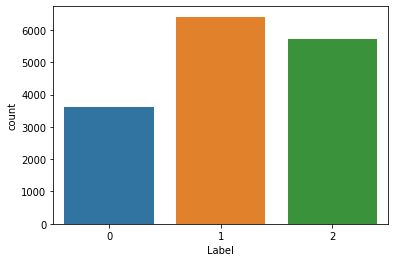

In [7]:
sns.countplot(df['Label'])

In [8]:
df.Label.value_counts(), len(df)

(1    6410
 2    5709
 0    3609
 Name: Label, dtype: int64,
 15728)

In [9]:
maxlen = 50
max_features = 10000
batch_size = 32

In [10]:
df['Token']=df['Token'].astype('str')

In [11]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df['Token'],df['Label'] , test_size=0.1,random_state=2)
x_train, x_validation, y_train, y_validation = train_test_split(x_train,y_train,test_size=0.1,random_state=42)

In [12]:
vocab_size=32000

In [13]:
tokenizer  = Tokenizer(num_words = max_features,oov_token = "<OOV>")
tokenizer.fit_on_texts(df['Token'])

train_seq =  tokenizer.texts_to_sequences(x_train)
val_seq =  tokenizer.texts_to_sequences(x_validation)
test_seq = tokenizer.texts_to_sequences(x_test)

In [14]:
x_train = pad_sequences(train_seq, maxlen=maxlen, dtype='int32', padding='post',truncating='post') #maxlen = maxlen, padding='post')
x_validation = pad_sequences(val_seq, maxlen=maxlen, dtype='int32', padding='post',truncating='post') #maxlen = maxlen, padding='post')
x_test = pad_sequences(test_seq, maxlen=maxlen, dtype='int32', padding='post',truncating='post') #maxlen = maxlen, padding='post')

In [15]:
model= Sequential()
model.add(Embedding(vocab_size,100,input_length=maxlen,name='Embedding'))
model.add(Conv1D(200, kernel_size=3, activation = "relu"))
model.add(GlobalMaxPooling1D())
model.add(Dropout(0.25))
model.add(Dense(100, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(50, activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(25, activation='relu'))
model.add(Dropout(0.1))
model.add(Dense(12, activation='relu'))
model.add(Flatten())
model.add(Dense(units=3, activation='softmax'))
adam=Adam(learning_rate=0.003)
model.summary()
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
Embedding (Embedding)        (None, 50, 100)           3200000   
_________________________________________________________________
conv1d (Conv1D)              (None, 48, 200)           60200     
_________________________________________________________________
global_max_pooling1d (Global (None, 200)               0         
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 100)               20100     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 50)                5

2023-01-29 00:44:05.816562: I tensorflow/core/common_runtime/process_util.cc:146] Creating new thread pool with default inter op setting: 2. Tune using inter_op_parallelism_threads for best performance.


In [16]:
early_stopping = keras.callbacks.EarlyStopping(
    patience=15,
    min_delta=0.001,
    restore_best_weights=True,
)

In [17]:
history = model.fit(x_train, y_train, batch_size=batch_size, epochs=30, callbacks=[early_stopping],verbose=1, validation_data=(x_validation, y_validation))

2023-01-29 00:44:06.282268: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/30
399/399 [==============================] - 16s 37ms/step - loss: 0.9470 - accuracy: 0.5201 - val_loss: 0.8115 - val_accuracy: 0.6398
Epoch 2/30
399/399 [==============================] - 15s 38ms/step - loss: 0.6633 - accuracy: 0.7333 - val_loss: 0.7330 - val_accuracy: 0.6843
Epoch 3/30
399/399 [==============================] - 15s 37ms/step - loss: 0.4309 - accuracy: 0.8441 - val_loss: 0.7883 - val_accuracy: 0.6907
Epoch 4/30
399/399 [==============================] - 15s 38ms/step - loss: 0.2707 - accuracy: 0.9064 - val_loss: 0.9868 - val_accuracy: 0.6737
Epoch 5/30
399/399 [==============================] - 15s 36ms/step - loss: 0.1719 - accuracy: 0.9440 - val_loss: 1.1899 - val_accuracy: 0.6688
Epoch 6/30
399/399 [==============================] - 15s 38ms/step - loss: 0.1209 - accuracy: 0.9605 - val_loss: 1.4016 - val_accuracy: 0.6766
Epoch 7/30
399/399 [==============================] - 15s 37ms/step - loss: 0.0983 - accuracy: 0.9659 - val_loss: 1.4938 - val_accuracy:

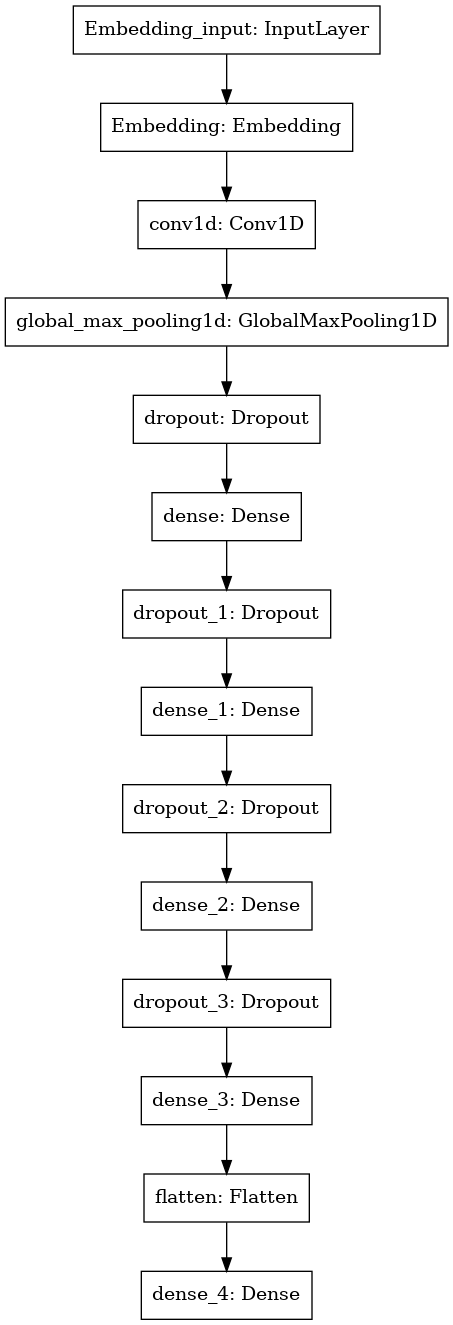

In [18]:
tf.keras.utils.plot_model(model, to_file='model.png', show_shapes=False,show_layer_names=True, rankdir='TB', expand_nested=False, dpi=96)

In [19]:
model.evaluate(x_test, y_test)

50/50 [==============================] - 0s 5ms/step - loss: 0.7419 - accuracy: 0.6904


[0.7418929934501648, 0.6904004812240601]

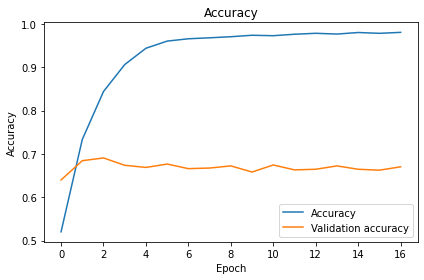

In [20]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'], label="Accuracy")
plt.plot(history.history['val_accuracy'], label="Validation accuracy")
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.savefig('3 classes CNN Val_acc.png',format='png',transparent='True')
plt.show()


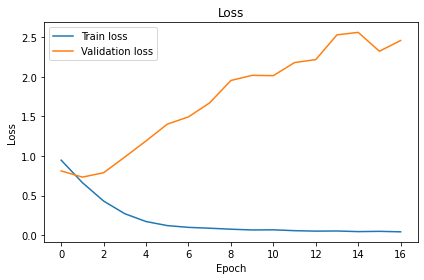

In [21]:
import matplotlib.pyplot as plt

plt.plot(history.history['loss'], label="Train loss")
plt.plot(history.history['val_loss'], label="Validation loss")
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.savefig('3 classes CNN Val_loss.png',format='png',transparent='True')
plt.show()

In [22]:
from sklearn.metrics import classification_report

y_pred_raw = model.predict(x_test)
y_pred = np.argmax(y_pred_raw,axis=1)

In [23]:
print(y_test.shape)
print(y_pred.shape)

(1573,)
(1573,)


In [24]:
y_pred = y_pred.reshape(-1,1)


In [25]:
categories = ['neutral','positive','negative']
print(classification_report(y_test, y_pred, target_names=categories))

              precision    recall  f1-score   support

     neutral       0.51      0.54      0.52       358
    positive       0.79      0.68      0.73       643
    negative       0.71      0.80      0.75       572

    accuracy                           0.69      1573
   macro avg       0.67      0.67      0.67      1573
weighted avg       0.70      0.69      0.69      1573



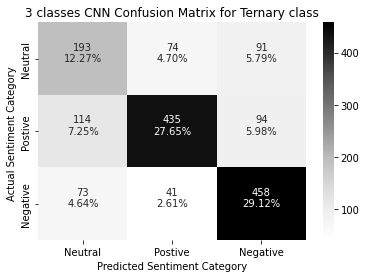

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(3,3)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Greys')

ax.set_title('3 classes CNN Confusion Matrix for Ternary class');
ax.set_xlabel('Predicted Sentiment Category')
ax.set_ylabel('Actual Sentiment Category ');

ax.xaxis.set_ticklabels(['Neutral','Postive', 'Negative'])
ax.yaxis.set_ticklabels(['Neutral','Postive', 'Negative'])
sns.set(color_codes=True)
sns.set(font_scale=1.3)
plt.savefig('3 classes CNN Confusion Matrix for Ternary class.png', bbox_inches = "tight")
plt.show()

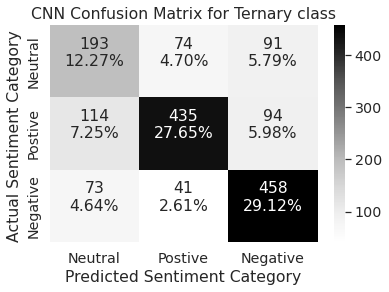

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
cf_matrix = confusion_matrix(y_test, y_pred)
group_counts = ["{0:0.0f}".format(value) for value in
                cf_matrix.flatten()]

group_percentages = ["{0:.2%}".format(value) for value in
                     cf_matrix.flatten()/np.sum(cf_matrix)]

labels = [f"{v1}\n{v2}\n" for v1, v2 in
          zip(group_counts,group_percentages)]

labels = np.asarray(labels).reshape(3,3)

ax = sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Greys')

ax.set_title('CNN Confusion Matrix for Ternary class');
ax.set_xlabel('Predicted Sentiment Category')
ax.set_ylabel('Actual Sentiment Category ');

ax.xaxis.set_ticklabels(['Neutral','Postive', 'Negative'])
ax.yaxis.set_ticklabels(['Neutral','Postive', 'Negative'])
sns.set(color_codes=True)
sns.set(font_scale=1.3)
plt.savefig('3 classes CNN Confusion Matrix.png', bbox_inches = "tight")
plt.show()

Accuracy: 0.69
Auc: 0.84
Detail:
              precision    recall  f1-score   support

           0       0.51      0.54      0.52       358
           1       0.79      0.68      0.73       643
           2       0.71      0.80      0.75       572

    accuracy                           0.69      1573
   macro avg       0.67      0.67      0.67      1573
weighted avg       0.70      0.69      0.69      1573



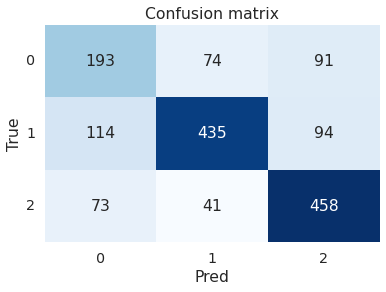

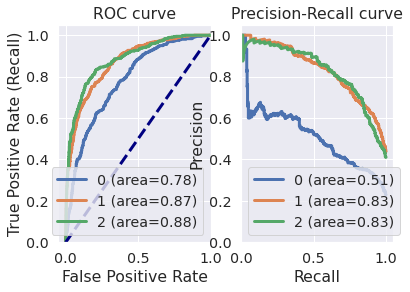

In [28]:
#!pip install metrics
import sklearn.metrics as metrics
classes = np.unique(y_test)
y_test_array = pd.get_dummies(y_test, drop_first=False).values
    
## Accuracy, Precision, Recall
accuracy = metrics.accuracy_score(y_test, y_pred)
auc = metrics.roc_auc_score(y_test, y_pred_raw, 
                            multi_class="ovr")
print("Accuracy:",  round(accuracy,2))
print("Auc:", round(auc,2))
print("Detail:")
print(metrics.classification_report(y_test, y_pred))
    
## Plot confusion matrix
cm = metrics.confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots()
sns.heatmap(cm, annot=True, fmt='d', ax=ax, cmap=plt.cm.Blues, 
            cbar=False)
ax.set(xlabel="Pred", ylabel="True", xticklabels=classes, 
       yticklabels=classes, title="Confusion matrix")
plt.yticks(rotation=0)

fig, ax = plt.subplots(nrows=1, ncols=2)
## Plot roc
for i in range(len(classes)):
    fpr, tpr, thresholds = metrics.roc_curve(y_test_array[:,i],  
                           y_pred_raw[:,i])
    ax[0].plot(fpr, tpr, lw=3, 
              label='{0} (area={1:0.2f})'.format(classes[i], 
                              metrics.auc(fpr, tpr))
               )
ax[0].plot([0,1], [0,1], color='navy', lw=3, linestyle='--')
ax[0].set(xlim=[-0.05,1.0], ylim=[0.0,1.05], 
          xlabel='False Positive Rate', 
          ylabel="True Positive Rate (Recall)", 
          title="ROC curve")
ax[0].legend(loc="lower right")
ax[0].grid(True)
plt.savefig('3 classes CNN ROC.png', bbox_inches = "tight")
    
## Plot precision-recall curve
for i in range(len(classes)):
    precision, recall, thresholds = metrics.precision_recall_curve(
                 y_test_array[:,i], y_pred_raw[:,i])
    ax[1].plot(recall, precision, lw=3, 
               label='{0} (area={1:0.2f})'.format(classes[i], 
                                  metrics.auc(recall, precision))
              )
ax[1].set(xlim=[0.0,1.05], ylim=[0.0,1.05], xlabel='Recall', 
          ylabel="Precision", title="Precision-Recall curve")
ax[1].legend(loc="best")
ax[1].grid(True)
plt.savefig('3 classes CNN precision-recall curve.png', bbox_inches = "tight")
plt.show()
